# Refined CNN with modern design
In this CNN we use residual connections, batch normalisation after each Convolution block, and Depth-Separable Convolution

In [11]:
from tensorflow.data import Dataset
from keras.utils import image_dataset_from_directory
from keras import layers, Model, Input
from keras.callbacks import EarlyStopping, TensorBoard  
import os
from shutil import rmtree
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import classification_report
from keras.optimizers import Adam
from keras.applications import xception
import numpy as np
import pandas as pd
from keras.utils import plot_model

SOURCE = '/home/mniederer/workspace/data/new_data'
LOG_DIR = '/home/mniederer/workspace/Geo-KI/logs/CNN_material_new_data'
SOURCE_DATAFRAME = '/home/mniederer/workspace/data/new_material/umrisse_with_all_data.csv'
BATCH_SIZE = 25
EPOCHS = 40

### Load data

In [12]:
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, Model, Input
from keras.callbacks import EarlyStopping, TensorBoard  
import os
from shutil import rmtree
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import classification_report
from keras.optimizers import Adam
from keras.applications import xception
import numpy as np

SOURCE = '/home/mniederer/workspace/data/new_data'
LOG_DIR = '/home/mniederer/workspace/Geo-KI/logs/CNN_material_new_data'
BATCH_SIZE = 25
EPOCHS = 40

# remove logs from previous executions
if os.path.isdir(os.path.join(LOG_DIR, 'train')):
    rmtree(os.path.join(LOG_DIR, 'train'))
if os.path.isdir(os.path.join(LOG_DIR, 'validation')):
    rmtree(os.path.join(LOG_DIR, 'validation'))


train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   #shear_range=10,
                                   #zoom_range=0.2,
                                   brightness_range=[0.9,1.1],
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   #fill_mode='reflect'
                                   )
train_generator = train_datagen.flow_from_directory(os.path.join(SOURCE,'train'), 
                                                    target_size=(150, 150), 
                                                    batch_size=BATCH_SIZE, 
                                                    class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(os.path.join(SOURCE,'validation'), 
                                                    target_size=(150, 150), 
                                                    batch_size=BATCH_SIZE, 
                                                    class_mode='categorical')

# create test generator, important: shuffle=False so I can indentify the sources with test_generator.filenames
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(os.path.join(SOURCE,'test'), 
                                                    target_size=(150, 150), 
                                                    batch_size=BATCH_SIZE, 
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 5768 images belonging to 11 classes.
Found 1236 images belonging to 11 classes.
Found 1243 images belonging to 11 classes.


### View Data Augmentation results

In [1]:
(x,y) = train_generator.next()
print(x.shape)
for i in range(x.shape[0]):
    image = x[i]
    plt.imshow(image)
    plt.show()

NameError: name 'train_generator' is not defined

## Optimization with KerasTuner

In [9]:
import keras_tuner as kt
from keras import layers
from tensorflow import keras
from keras.callbacks import EarlyStopping

def model_builder(hp):
    inputs = keras.Input(shape=(150,150,3), name='InputLayer')
    x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False, name='Conv0')(inputs)

    units_1 = hp.Int('units_1', min_value=64, max_value=512, step=32)
    units_2 = hp.Int('units_2', min_value=32, max_value=256, step=16)
    hp_dropout_rate = hp.Choice('dropout_rate', values=[0.3, 0.35, 0.4, 0.45, 0.5 ])

    for i in [1,2,3,4, 5]: #maybe also 5
        size = pow(2,(i + 4))

        residual = x

        x = layers.BatchNormalization(name='Normalization'+str(i)+'_1')(x)
        x = layers.Activation("relu", name='ReLu'+str(i)+'_1')(x)
        x = layers.SeparableConv2D(size, 7, padding="same", use_bias=False, name= 'SepConv' + str(i) +'_1')(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same", name='Pool'+str(i))(x)

        residual = layers.Conv2D(
            size, 1, strides=2, padding="same", use_bias=False, name='ResidualProjection'+str(i))(residual)
        x = layers.add([x, residual], name='AddResidual'+str(i))

    x = layers.GlobalAveragePooling2D(name='GlobalAveragePool')(x) # flatten layer to connect to classifier
    x = layers.Dropout(hp_dropout_rate, name='Dropout50')(x) # add Dropout to prevent overfitting

    # Classifier
    x = layers.Dense(units_1, activation='relu', name='Dense256')(x)
    x = layers.Dense(units_2, activation='relu', name='Dense64')(x)
    outputs = layers.Dense(11, activation='softmax', name='OutputLayer')(x)

    model = keras.Model(inputs=inputs, outputs=outputs) 
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt',
                     overwrite=True)

stop_early = EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_generator, validation_data=validation_generator, epochs=30, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 30m 34s]
val_accuracy: 0.5849514603614807

Best val_accuracy So Far: 0.6351132392883301
Total elapsed time: 11h 51m 13s
INFO:tensorflow:Oracle triggered exit


In [10]:
print(best_hps.get('units_1'))
print(best_hps.get('units_2'))
print(best_hps.get('dropout_rate'))

256
240
0.5


first trial: 128, 240, 0.3
second trial: 256, 240 , 0.5

## Model Chollet

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputLayer (InputLayer)        [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv0 (Conv2D)                 (None, 150, 150, 32  2400        ['InputLayer[0][0]']             
                                )                                                                 
                                                                                                  
 Normalization1_1 (BatchNormali  (None, 150, 150, 32  128        ['Conv0[0][0]']                  
 zation)                        )                                                           

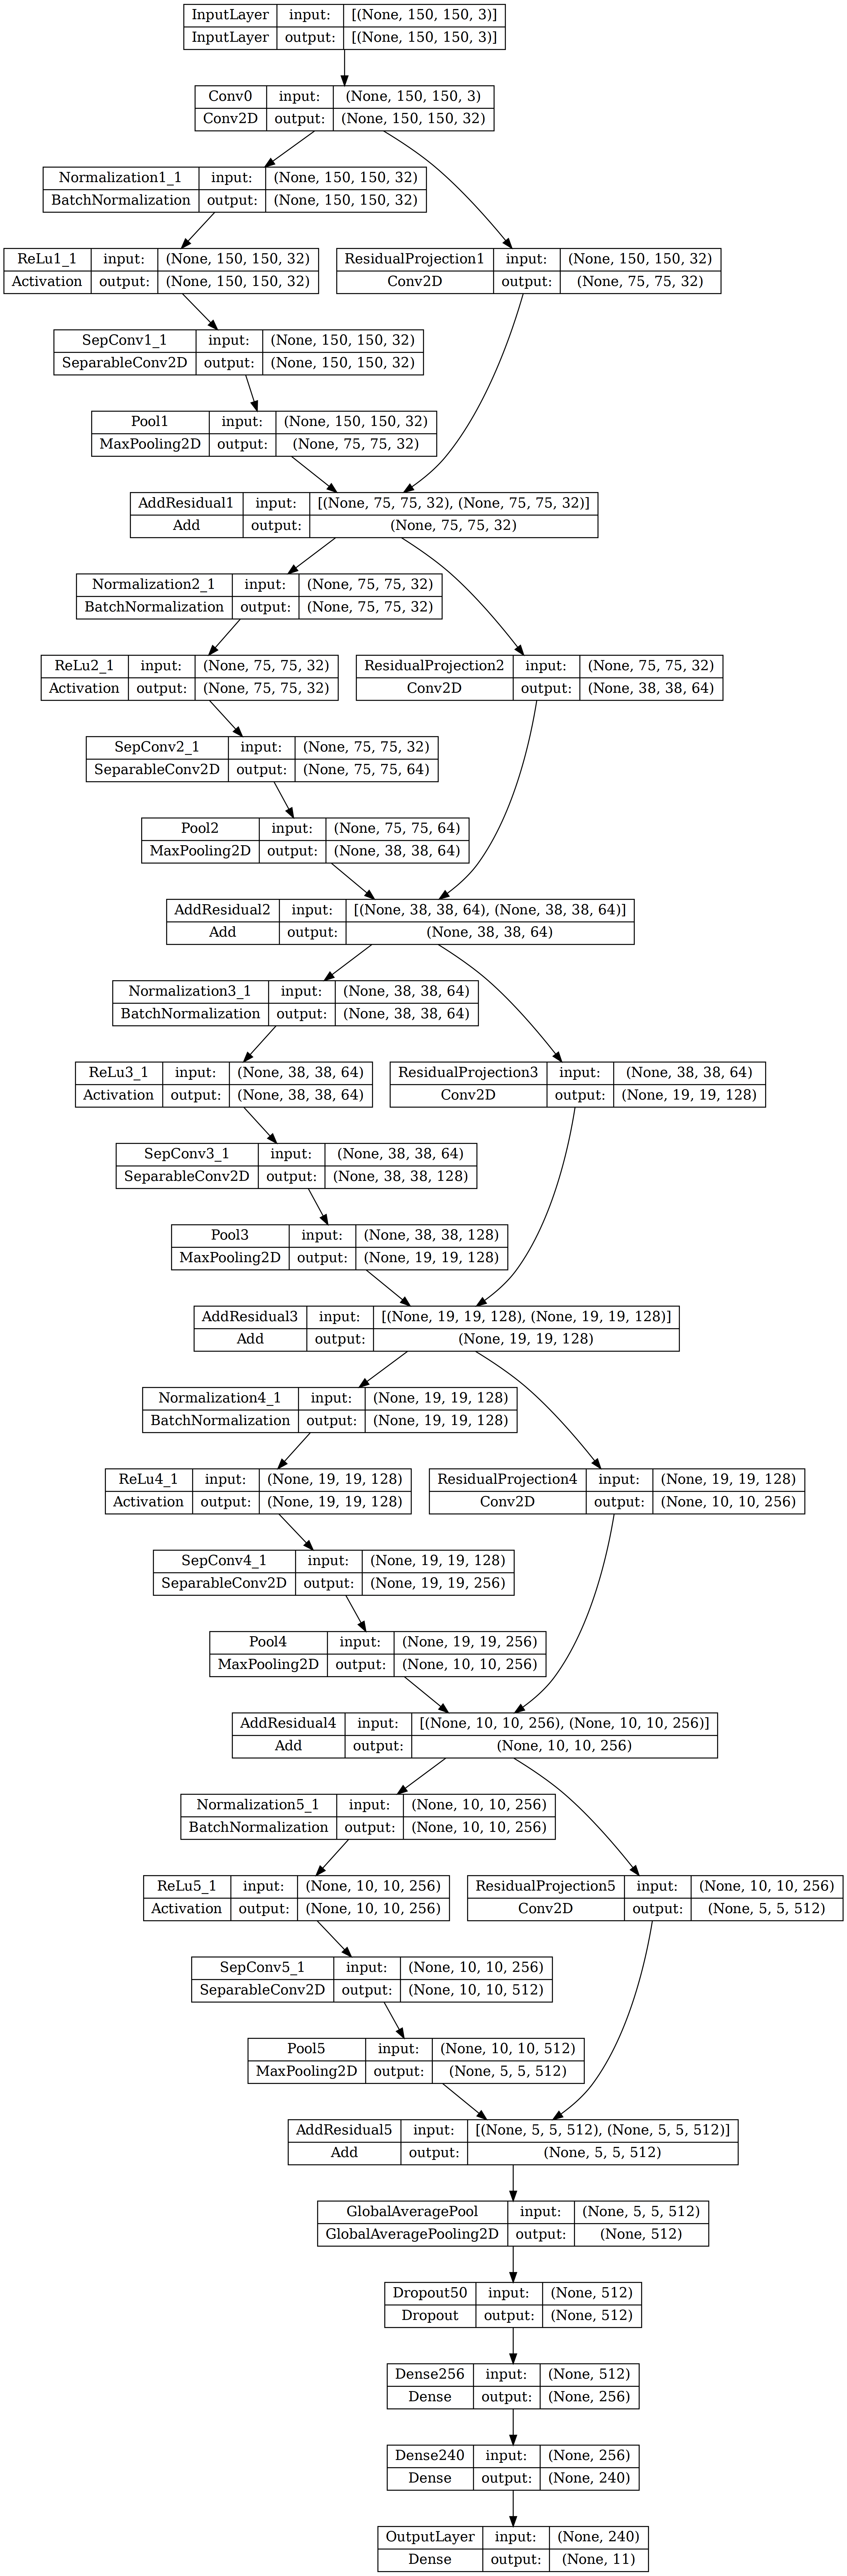

In [17]:
from keras import layers
from tensorflow import keras

inputs = keras.Input(shape=(150,150,3), name='InputLayer')
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False, name='Conv0', padding='same')(inputs)

for i in [1,2,3,4, 5]: #maybe also 5
    size = pow(2,(i + 4))

    residual = x

    x = layers.BatchNormalization(name='Normalization'+str(i)+'_1')(x)
    x = layers.Activation("relu", name='ReLu'+str(i)+'_1')(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False, name= 'SepConv' + str(i) +'_1')(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same", name='Pool'+str(i))(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False, name='ResidualProjection'+str(i))(residual)
    x = layers.add([x, residual], name='AddResidual'+str(i))

x = layers.GlobalAveragePooling2D(name='GlobalAveragePool')(x) # flatten layer to connect to classifier
x = layers.Dropout(0.5, name='Dropout50')(x) # add Dropout to prevent overfitting

# Classifier
x = layers.Dense(256, activation='relu', name='Dense256')(x)
x = layers.Dense(240, activation='relu', name='Dense240')(x)
outputs = layers.Dense(11, activation='softmax', name='OutputLayer')(x)


model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

plot_model(model, to_file='Pictures/Complex_CNN.png', show_shapes=True, expand_nested=True, dpi=250)

## Model architecture

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputLayer (InputLayer)        [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 146, 146, 64  4864        ['InputLayer[0][0]']             
                                )                                                                 
                                                                                                  
 Pool1 (MaxPooling2D)           (None, 73, 73, 64)   0           ['Conv1[0][0]']                  
                                                                                            

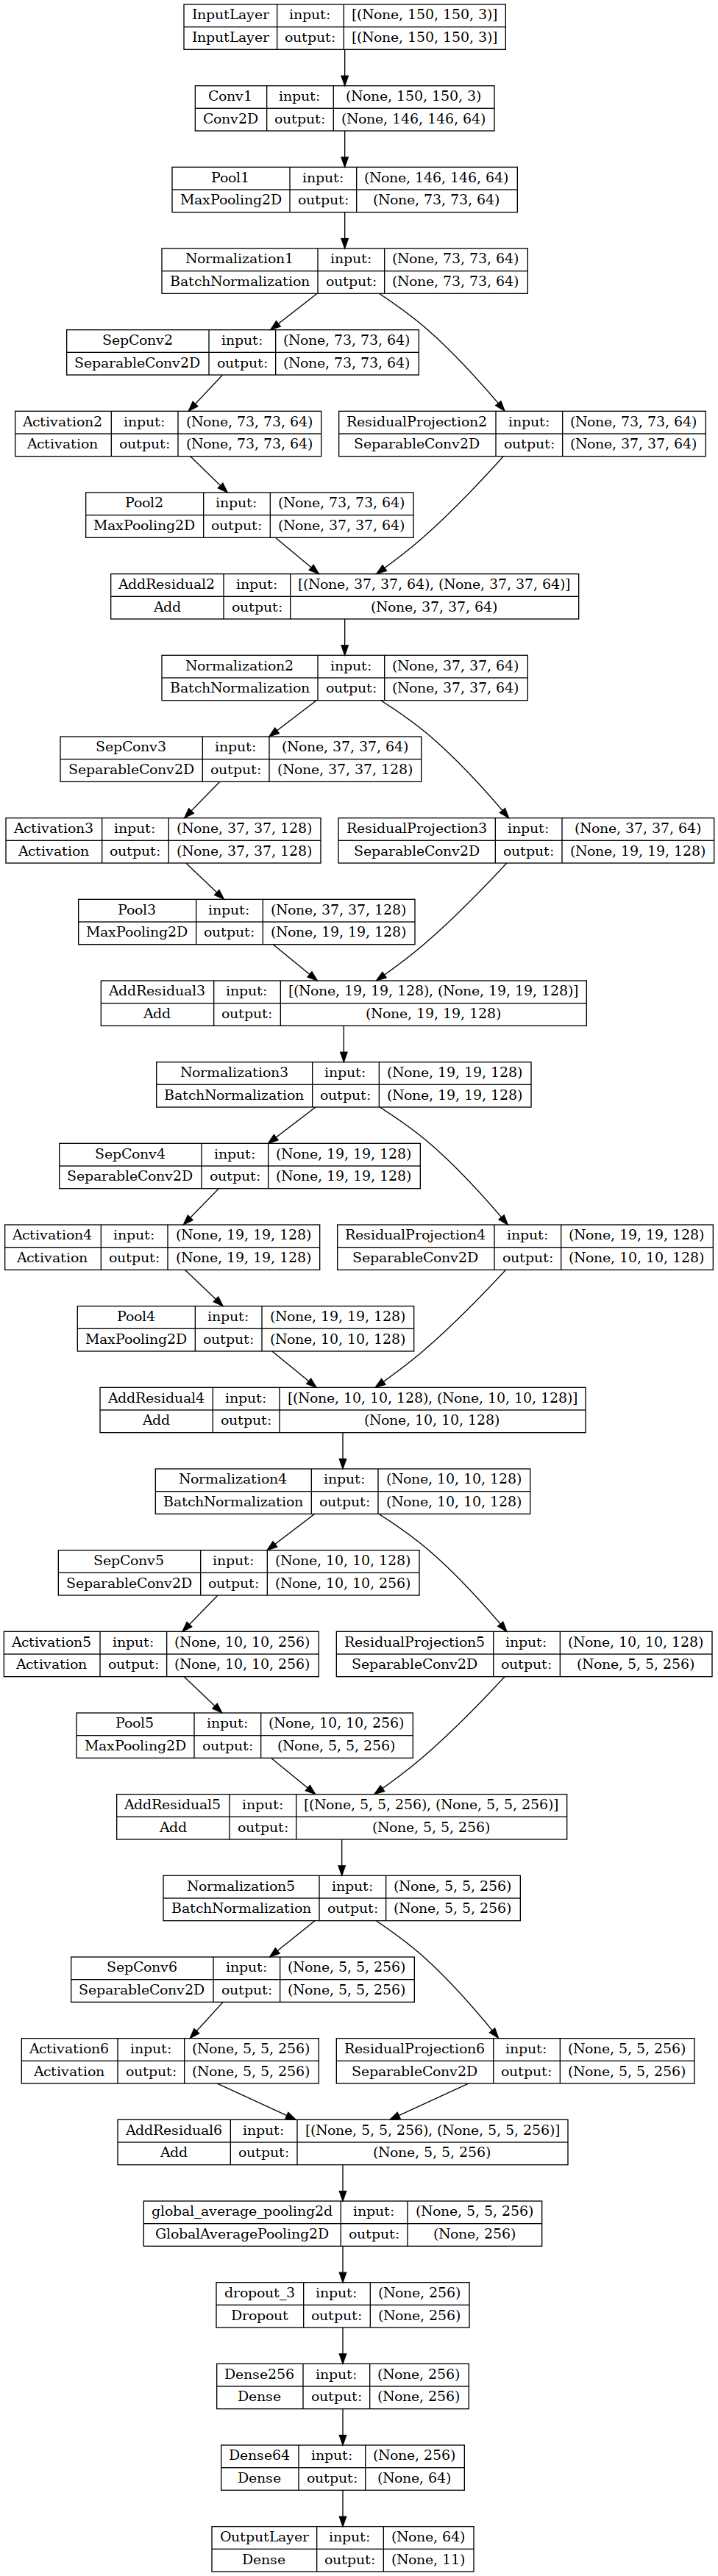

In [ ]:
from keras import layers
from tensorflow import keras

inputs = keras.Input(shape=(150,150,3), name='InputLayer')

#first block
x = layers.Conv2D(64, kernel_size=3, use_bias=True, activation='relu', name='Conv1')(inputs)
x = layers.MaxPooling2D(pool_size=2, padding='same', name='Pool1')(x)
x = layers.BatchNormalization(name='Normalization1')(x)

# second block
residual = x

x = layers.SeparableConv2D(filters=64, kernel_size=3, padding='same', use_bias=False, name='SepConv2')(x)
x = layers.Activation('relu', name='Activation2')(x)
x = layers.MaxPooling2D(pool_size=2, padding='same', name='Pool2')(x)

residual = layers.SeparableConv2D(filters=64, kernel_size=1, strides=2, padding='same', use_bias=False, name='ResidualProjection2')(residual) # transform shape of residual to fit output

x = layers.Add(name='AddResidual2')([x, residual])  # add residual connection to counteract vanishing gradients
x = layers.BatchNormalization(name='Normalization2')(x) # normalize features for next block



# third block
residual = x

x = layers.SeparableConv2D(filters=128, kernel_size=3, padding='same', use_bias=False, name='SepConv3')(x)
x = layers.Activation('relu', name='Activation3')(x)
x = layers.MaxPooling2D(pool_size=2, padding='same', name='Pool3')(x)

residual = layers.SeparableConv2D(filters=128, kernel_size=1, strides=2, padding='same', use_bias=False, name='ResidualProjection3')(residual) # transform shape of residual to fit output

x = layers.Add(name='AddResidual3')([x, residual])  # add residual connection to counteract vanishing gradients
x = layers.BatchNormalization(name='Normalization3')(x) # normalize features for next block


# forth block
residual = x

x = layers.SeparableConv2D(filters=128, kernel_size=3, padding='same', use_bias=False, name='SepConv4')(x)
x = layers.Activation('relu', name='Activation4')(x)
x = layers.MaxPooling2D(pool_size=2, padding='same', name='Pool4')(x)

residual = layers.SeparableConv2D(filters=128, kernel_size=1, strides=2, padding='same', use_bias=False, name='ResidualProjection4')(residual) # transform shape of residual to fit output

x = layers.Add(name='AddResidual4')([x, residual])  # add residual connection to counteract vanishing gradients
x = layers.BatchNormalization(name='Normalization4')(x) # normalize features for next block

# fifth block
residual = x

x = layers.SeparableConv2D(filters=256, kernel_size=3, padding='same', use_bias=False, name='SepConv5')(x)
x = layers.Activation('relu', name='Activation5')(x)
x = layers.MaxPooling2D(pool_size=2, padding='same', name='Pool5')(x)

residual = layers.SeparableConv2D(filters=256, kernel_size=1, strides=2, padding='same', use_bias=False, name='ResidualProjection5')(residual) # transform shape of residual to fit output

x = layers.Add(name='AddResidual5')([x, residual])  # add residual connection to counteract vanishing gradients
x = layers.BatchNormalization(name='Normalization5')(x) # normalize features for next block


# sixth block
residual = x

x = layers.SeparableConv2D(filters=256, kernel_size=3, padding='same', use_bias=False, name='SepConv6')(x)
x = layers.Activation('relu', name='Activation6')(x)

residual = layers.SeparableConv2D(filters=256, kernel_size=1, padding='same', use_bias=False, name='ResidualProjection6')(residual)

x = layers.Add(name='AddResidual6')([x, residual])

x = layers.GlobalAveragePooling2D()(x) # flatten layer to connect to classifier
x = layers.Dropout(0.5)(x) # add Dropout to prevent overfitting

# Classifier
x = layers.Dense(256, activation='relu', name='Dense256')(x)
x = layers.Dense(64, activation='relu', name='Dense64')(x)
outputs = layers.Dense(11, activation='softmax', name='OutputLayer')(x)


model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

plot_model(model, to_file='Pictures/Complex_CNN.png', show_shapes=True, expand_nested=True)

## Training model

In [18]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
best_weights_path = './best_weights.keras'

model_checkpoint_callback = ModelCheckpoint(
    filepath= best_weights_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stopping_callback = EarlyStopping('val_accuracy', patience=15, min_delta=0.001)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_generator, batch_size=64, epochs=50, verbose=1,
          callbacks=[model_checkpoint_callback],
          validation_data=validation_generator)

model.load_weights(best_weights_path)

Epoch 1/60
231/231 [==============================] - 239s 1s/step - loss: 1.3499 - accuracy: 0.5581 - val_loss: 2.1064 - val_accuracy: 0.1804
Epoch 2/60
231/231 [==============================] - 216s 933ms/step - loss: 1.2386 - accuracy: 0.5858 - val_loss: 1.4388 - val_accuracy: 0.5316
Epoch 3/60
231/231 [==============================] - 231s 1s/step - loss: 1.2056 - accuracy: 0.5978 - val_loss: 1.3297 - val_accuracy: 0.5647
Epoch 4/60
231/231 [==============================] - 242s 1s/step - loss: 1.1792 - accuracy: 0.6033 - val_loss: 1.2474 - val_accuracy: 0.5906
Epoch 5/60
231/231 [==============================] - 243s 1s/step - loss: 1.1593 - accuracy: 0.6141 - val_loss: 1.4238 - val_accuracy: 0.5841
Epoch 6/60
231/231 [==============================] - 245s 1s/step - loss: 1.1337 - accuracy: 0.6163 - val_loss: 1.2981 - val_accuracy: 0.5647
Epoch 7/60
231/231 [==============================] - 216s 933ms/step - loss: 1.1231 - accuracy: 0.6233 - val_loss: 4.6095 - val_accuracy: 

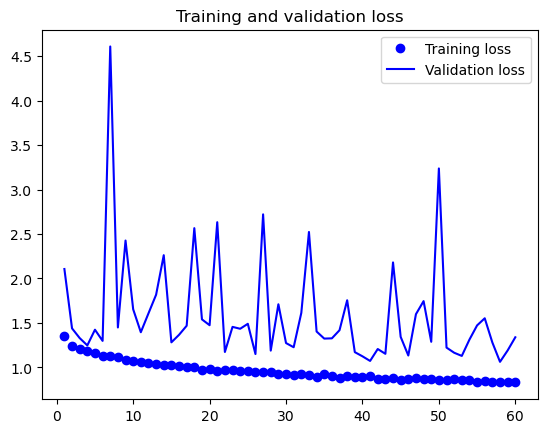

In [19]:
from matplotlib import pyplot as plt

epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

### Evaluation

In [20]:
score=model.evaluate(test_generator)

print("Test score:", score[0])
print("Test accuracy:", score[1])

50/50 [==============================] - 4s 74ms/step - loss: 1.0782 - accuracy: 0.6557
Test score: 1.0782170295715332
Test accuracy: 0.6556717753410339


In [ ]:
model.save('CNN_complex.h5')

# Investigation of model

## Visualizing filters

### layer names

In [ ]:
for layer in model.layers:
    print(layer.name)

input_7
conv2d_6
max_pooling2d_22
batch_normalization_32
separable_conv2d_63
activation_32
max_pooling2d_23
separable_conv2d_64
add_32
batch_normalization_33
separable_conv2d_65
activation_33
max_pooling2d_24
separable_conv2d_66
add_33
batch_normalization_34
separable_conv2d_67
activation_34
max_pooling2d_25
separable_conv2d_68
add_34
batch_normalization_35
separable_conv2d_69
activation_35
max_pooling2d_26
separable_conv2d_70
add_35
batch_normalization_36
separable_conv2d_71
activation_36
separable_conv2d_72
add_36
flatten_4
dropout_4
dense_8
dense_9


### Create feature extractor model

In [ ]:
# create model
layer_name = "separable_conv2d_38"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

ValueError: No such layer: separable_conv2d_38. Existing layers are: ['input_7', 'conv2d_6', 'max_pooling2d_22', 'batch_normalization_32', 'separable_conv2d_63', 'activation_32', 'max_pooling2d_23', 'separable_conv2d_64', 'add_32', 'batch_normalization_33', 'separable_conv2d_65', 'activation_33', 'max_pooling2d_24', 'separable_conv2d_66', 'add_33', 'batch_normalization_34', 'separable_conv2d_67', 'activation_34', 'max_pooling2d_25', 'separable_conv2d_68', 'add_34', 'batch_normalization_35', 'separable_conv2d_69', 'activation_35', 'max_pooling2d_26', 'separable_conv2d_70', 'add_35', 'batch_normalization_36', 'separable_conv2d_71', 'activation_36', 'separable_conv2d_72', 'add_36', 'flatten_4', 'dropout_4', 'dense_8', 'dense_9'].

### Create loss function
The loss function is calculates how much a given input activates the specific filter

In [ ]:
import tensorflow as tf

def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_sum(filter_activation)

### Maximize loss with gradient ascent

In [ ]:
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_index)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return image

### Function to generate filter visualizations

In [ ]:
img_width = 150
img_height = 150

def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.
    image = tf.random.uniform(
        minval=0.4,
        maxval=0.6,
        shape=(1, img_width, img_height, 3))
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()

### Utility function to convert a tensor into a valid image

In [ ]:
def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :]
    return image

### Put it all together

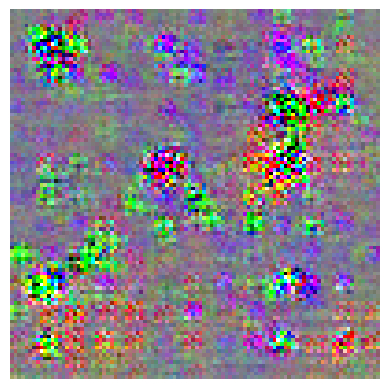

In [ ]:
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=7)))
plt.show()

### Generating a grid of all filter response patterns in a layer

In [ ]:
all_images = []
for filter_index in range(64):
    print(f"Processing filter {filter_index}")
    image = deprocess_image(
        generate_filter_pattern(filter_index)
    )
    all_images.append(image)

margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
    for j in range(n):
        image = all_images[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = image

keras.utils.save_img(
    f"filters_for_layer_{layer_name}.png", stitched_filters)

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr